In [2]:
import os
import numpy as np
import cv2
from PIL import Image
import json
from matplotlib import pyplot as plt
import pandas as pd

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [3]:
path = './scan_doc_rotation/'

['scan_000.png', 'scan_001.png', 'scan_002.png', 'scan_003.png', 'scan_004.png', 'scan_005.png', 'scan_006.png', 'scan_007.png', 'scan_008.png', 'scan_009.png']
Total number of images: 600


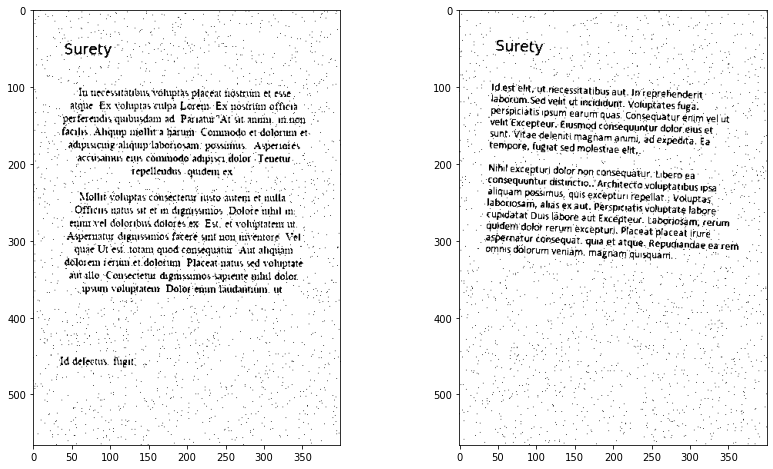

In [4]:
# Load and open images
names = [ file for file in os.listdir(path+'images/') ]
names = sorted(names)
N = len(names)

print(names[:10])

# Load two images to check
images = [Image.open(path+'images/'+names[i]) for i in range(2)]

plt.figure(figsize=(14,8))
plt.subplot(121),plt.imshow(images[0], cmap = 'gray')
plt.subplot(122),plt.imshow(images[1], cmap = 'gray')

print('Total number of images: %d'%N)

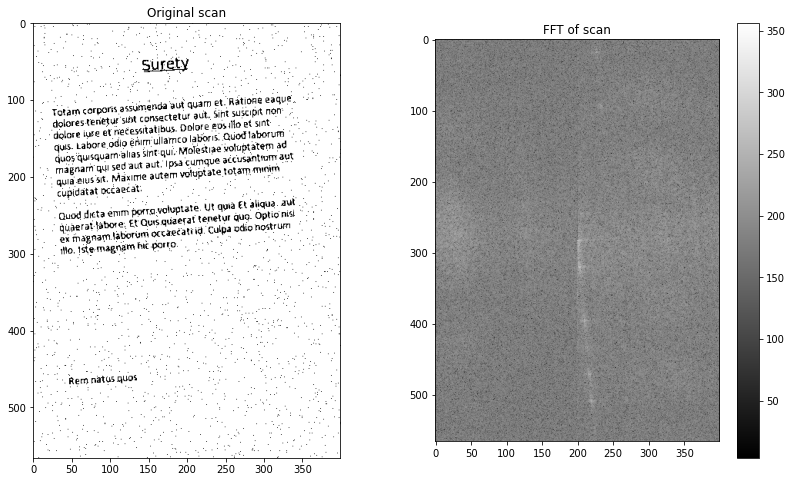

In [5]:
eg_img = path+'/images/'+names[18]
img = cv2.imread(eg_img)
img = img[:,:,0] #zeroth component is the red from RGB channel ordering
f = cv2.dft(np.float32(img))
fshift = np.fft.fftshift(f)
f_abs = np.abs(fshift) + 1.0 #shift to ensure no zeroes are present in image array
f_img = 20 * np.log(f_abs)

plt.figure(figsize=(14,8))

plt.subplot(121),plt.imshow(img, 'gray')
plt.title('Original scan')

plt.subplot(122),plt.imshow(f_img, 'gray')
plt.title('FFT of scan')
plt.colorbar() 
plt.show()

<ipython-input-6-a73035416a93>:3: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)


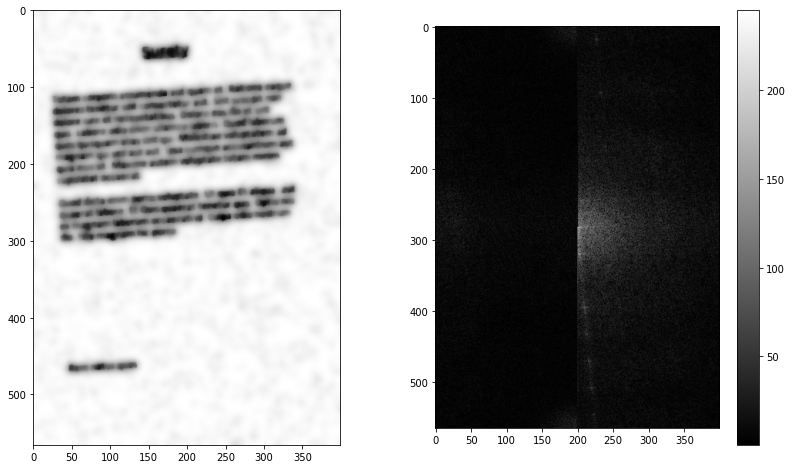

In [6]:
from skimage.restoration import denoise_tv_chambolle

img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)

f = cv2.dft(np.float32(img))
fshift = np.fft.fftshift(f)
f_abs = np.abs(fshift) + 1.0
f_img = 20 * np.log(f_abs)

plt.figure(figsize=(14,8))
plt.subplot(121),plt.imshow(img, 'gray')
plt.subplot(122),plt.imshow(f_img, 'gray')
os.system('mkdir -p ./processed')
cv2.imwrite(path+'/processed/'+names[18], f_img)
plt.colorbar() 
plt.show()

In [7]:
fft_images = []
for i in range(N):
    img = cv2.imread(path+'/images/'+names[i])
    img = img[:,:,0]
    img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)
    f = cv2.dft(np.float32(img))
    fshift = np.fft.fftshift(f)
    f_abs = np.abs(fshift) + 1.0 # shift to avoid np.log(0) = nan
    f_img = 20 * np.log(f_abs)
    fft_images.append( f_img )
    cv2.imwrite(path+'/processed/'+names[i], f_img)

<ipython-input-7-03e16059f11c>:5: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)


In [8]:
# Load and open labels
label_names = [ file for file in os.listdir(path+'./labels') ]
label_names = sorted(label_names)
M = len(label_names)

print(label_names[:10])

labels = [ np.loadtxt(path+'./labels/'+label_names[j])
for j in range(M) ]
labels = [ round(float(labels[j])) for j in range(M) ]

# Load first 10 labels
[print(labels[i]) for i in range(10)]
print('Total number of labels %d'%len(labels))

['scan_000.txt', 'scan_001.txt', 'scan_002.txt', 'scan_003.txt', 'scan_004.txt', 'scan_005.txt', 'scan_006.txt', 'scan_007.txt', 'scan_008.txt', 'scan_009.txt']
0
-2
-5
-5
-1
-1
4
0
-5
-2
Total number of labels 500


In [9]:
# Deserialize JSON data lists for training and test sets
with open(path+'train_list.json') as train_data:
    train = json.load(train_data)
    
train_size = len(train)
print('Training set size: %d'%train_size)

with open(path+'test_list.json') as test_data:
    test = json.load(test_data)
    
test_size = len(test)
print('Test set size: %d'%test_size)

Training set size: 500
Test set size: 100


In [10]:
# Get images into tensor form
image_arr = [ tf.keras.preprocessing.image.img_to_array(fft_images[i]) 
for i in range(N) ]

# get pixel dimensions of image
img_height = image_arr[0].shape[0]
img_width = image_arr[0].shape[1]

# Training and test image stacks
X_train = tf.stack(image_arr[:train_size], axis=0, name='train_set')
X_test = tf.stack(image_arr[-test_size:], axis=0, name='test_set')

pixel_count = img_height * img_width

# Reshape to 3D Tensor
X_train = np.array(X_train).reshape(train_size, pixel_count)
X_test = np.array(X_test).reshape(test_size, pixel_count)

# Normalise pixel values
X_train /= 255
X_test /= 255

# Training labels
Y_train_ = np.array(labels).reshape(len(labels))

# Check shape of each tensor
print(X_train.shape, Y_train_.shape)
print(X_test.shape)

(500, 226400) (500,)
(100, 226400)


In [11]:
# Show number of unique labels
classes = np.unique(Y_train_)
print(classes)
n_classes = len(np.unique(Y_train_))

# Create classes from unique labels
Y_train = to_categorical(Y_train_, n_classes)
print(Y_train.shape)

[-5 -4 -3 -2 -1  0  1  2  3  4  5]
(500, 11)


In [12]:
model = Sequential()

model.add(Dense(512, activation='relu', 
                input_shape=(pixel_count,)))

model.add(Dense(512, activation='relu'))

model.add(Dense(512, activation='relu'))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(n_classes, activation = 'softmax'))

In [13]:
model.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'] )

In [14]:
history = model.fit(X_train, Y_train, batch_size=32, epochs=25, verbose=2)

Epoch 1/25
16/16 - 18s - loss: 4.8119 - accuracy: 0.0960 - 18s/epoch - 1s/step
Epoch 2/25
16/16 - 16s - loss: 2.5061 - accuracy: 0.0960 - 16s/epoch - 975ms/step
Epoch 3/25
16/16 - 16s - loss: 2.4226 - accuracy: 0.0920 - 16s/epoch - 994ms/step
Epoch 4/25
16/16 - 16s - loss: 2.4013 - accuracy: 0.1180 - 16s/epoch - 982ms/step
Epoch 5/25
16/16 - 15s - loss: 2.3857 - accuracy: 0.1340 - 15s/epoch - 969ms/step
Epoch 6/25
16/16 - 16s - loss: 2.3266 - accuracy: 0.1800 - 16s/epoch - 1s/step
Epoch 7/25
16/16 - 16s - loss: 2.2574 - accuracy: 0.2100 - 16s/epoch - 998ms/step
Epoch 8/25
16/16 - 15s - loss: 2.0557 - accuracy: 0.1880 - 15s/epoch - 963ms/step
Epoch 9/25
16/16 - 17s - loss: 1.6933 - accuracy: 0.2860 - 17s/epoch - 1s/step
Epoch 10/25
16/16 - 17s - loss: 1.6118 - accuracy: 0.3280 - 17s/epoch - 1s/step
Epoch 11/25
16/16 - 17s - loss: 1.5734 - accuracy: 0.3100 - 17s/epoch - 1s/step
Epoch 12/25
16/16 - 18s - loss: 1.2433 - accuracy: 0.4800 - 18s/epoch - 1s/step
Epoch 13/25
16/16 - 16s - loss:

In [24]:
ftt_model = model.save('saved_model/fttmodel')

INFO:tensorflow:Assets written to: saved_model/fttmodel\assets


INFO:tensorflow:Assets written to: saved_model/fttmodel\assets


In [27]:
ftt_denoise = tf.keras.models.load_model('saved_model/fttmodel')

In [28]:
predict = ftt_denoise.predict(X_test)
# print(predictions)
predictions = np.argmax(predict, axis =1)
print(predictions)

4/4 [==============================] - 0s 52ms/step
[10 10 10 10 10 10  4  2  2 10  8  2  2 10 10  4  5  1 10 10 10  9  8  4
 10  4  2  4 10 10 10 10  8  5 10 10  5  1  9 10 10  2 10  4  4  9  2  4
  5  1  8 10  8  5  9  2  8 10  8 10 10 10  2  5  4  2 10  1 10 10  5  2
  2  5  9 10  4 10  1  4 10 10  4 10  2 10  1 10 10  4 10 10 10  1  4  8
  2  8  8  5]


In [29]:
df = pd.DataFrame({'Image name': names[-test_size:], 'Rotated angle (deg)': classes[predictions]})
df.head(10)

,Image name,Rotated angle (deg)
0,scan_500.png,5
1,scan_501.png,5
2,scan_502.png,5
3,scan_503.png,5
4,scan_504.png,5
5,scan_505.png,5
6,scan_506.png,-1
7,scan_507.png,-3
8,scan_508.png,-3
9,scan_509.png,5


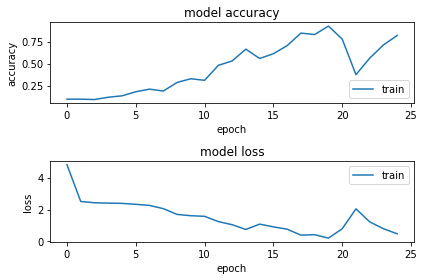

In [30]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()